# 8.2 从小数据集训练 cnn 网络

计算机视觉的模型,开始只有一个非常小的数据集是非常普遍的情况,这里的小数据集的规模可能从几百到几万不等.

这一节我们将专注于分类猫狗的模型,包含 5000 张图片(猫狗各一半),2000 训练,1000 验证,2000 测试.

回顾一下第 6 章的内容.

- 首先我们要实现一个小模型,能超过基线(50%)的那种.书中给的正确率是 70%.
- 之后要开始调整过拟合,通过数据增强,模型的正确率能达到 80%~85%.
- 之后 8.3 节,我们会介绍使用预训练模型和预训练模型微调,最终的正确率等达到 98.5%.

小数据集解决图像分类问题的工具箱

- 从头训练的小型模型
- 预训练的网络做特征提取
- 预训练网络微调


## 深度学习与小数据问题的相关性

深度学习的基础是数据,只有大量数据可用时,深度学习才会有效.这样的说话在哪都听说过,说的没错.深度学习的基本特性就在大量数据中找到模式,而无需人工干预的特征工程.这只有咋拥有大量样本时才能实现,尤其是对图像识别这样的高维数据.

但是对于初学者,这个大量是相对的.虽然只用几十个样本训练卷积神经网络解决问题是不可能的.但是如果问题较为简单,模型很小,正则化很好,那几百个样本可能就足够了.同时 cnn 学习的是局部的特征,对图像的利用更加高效,非常节约训练样本.

此外深度学习模型的本质具有高度的复用性,在一个大规模数据集上训练好的模型,只需要很小的修改就能复用在完全不同的问题上.在下一节中我们将会用到预训练的模型.


## 下载数据集

和之前的例子不同,我们要使用的数据集并没有包含在 keras 中,我们要用的数据集是 kaggle 提供的,是 2013 年底计算机视觉竞赛的一部分.需要在 `www.kaggle.com/c/dogs-vs-cats/data` 下载,下载前需要注册 kaggle 账号,同时经过手机号验证(+86 也没问题).

我们需要下载的是 train.zip 共 543MB.

原书提供了在 google colab 的下载方式,在这里 [Downloading a Kaggle dataset in Google Colaboratory](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-8/v-7/80)


图片都是 jpeg 格式,下面是一些示例图片.

![dog_and_cat_samples](dog_and_cat_samples.png)


当然不出预料,当年胜利的参赛者使用的都是 cnn,最好的效果达到了 95%.

这个数据集规模实在太大了,我们将取需要的数据,重新划分文件夹.

```shell
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```


In [1]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")  #存放原始数据的文件夹
new_base_dir = pathlib.Path("cats_vs_dogs_small")  # 小数据集文件夹


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)  #创建文件夹
        fnames = [
            f"{category}.{i}.jpg" for i in range(start_index, end_index)
        ]  #取源文件下需要图片
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)  #拷贝到新文件夹中


# make_subset("train", start_index=0, end_index=1000)  #训练集
# make_subset("validation", start_index=1000, end_index=1500)  #验证集
# make_subset("test", start_index=1500, end_index=2500)  #测试集


重新构建小数据集的程序如上,程序功能见注释.

现在我们拥有了一个非常平衡的二元数据集,包括 2000 张训练 1000 张验证 2000 张测试.


## 构建模型

我们这一小节要开始构建模型,类型与 8.1 小节类似,不过这里我们要处理的图片大得多,需要更多 cnn 和 maxpooling.


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

模型

- 最开始添加了一个缩放层,将图像输入 [0,255] 变成 [0,1]
- 5 个 cnn 层,4 个 maxpooling 层.
- 开始的输入是 180x180 ,最终输出是 7x7.
- 最终是二分类问题,因此最后是全连接层 1,激活函数是 sigmoid.


In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [4]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

模型设置

- 优化器: rmsprop,因为最终是 sigmoid.
- 损失函数: 二元交叉熵


## 预处理数据

jpeg 图像在输入模型前,需要张量化.这里因为有缩放层,数据缩放就不需要了.

具体步骤

- jpeg 解码成 rgb 像素
- 转换为 浮点张量
- 调整到同一尺寸,这里是 180x180
- 打包成批次大小,这里是 32


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir / "train",
                                             image_size=(180, 180),
                                             batch_size=32)  #训练集
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",
                                                  image_size=(180, 180),
                                                  batch_size=32)  #验证集
test_dataset = image_dataset_from_directory(new_base_dir / "test",
                                            image_size=(180, 180),
                                            batch_size=32)  #测试集


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


别忘了这里是 python keras,这样的重复工作肯定有工具箱.

`image_dataset_from_directory`

- 第一个参数是图像所在的目录
- image_size 是输出图像的大小,这里是 180x180
- batch_size 是批次大小,这里是 32

之后一切自动化,自动将图片转换为浮点张量,宽高调整为 180x180,打包成批次大小 32 的迭代器.


In [6]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


这里容易看到训练数据已经按照批次大小 32 打包好了.


In [7]:
callbacks = [  #回调
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,  #只保存最佳模型
        monitor="val_loss")  #监控的指标
]
history = model.fit(
    train_dataset,
    epochs=30,  #训练 30 次迭代
    validation_data=validation_dataset,  #验证集
    callbacks=callbacks)  #传入回调


Epoch 1/30
63/63 [==============================] - 10s 92ms/step - loss: 0.7977 - accuracy: 0.5250 - val_loss: 0.8441 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 63ms/step - loss: 0.7073 - accuracy: 0.5375 - val_loss: 0.7458 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6925 - accuracy: 0.5500 - val_loss: 0.7016 - val_accuracy: 0.5290
Epoch 4/30
63/63 [==============================] - 4s 65ms/step - loss: 0.6607 - accuracy: 0.6265 - val_loss: 0.6546 - val_accuracy: 0.6340
Epoch 5/30
63/63 [==============================] - 4s 67ms/step - loss: 0.6094 - accuracy: 0.6640 - val_loss: 0.6150 - val_accuracy: 0.6940
Epoch 6/30
63/63 [==============================] - 4s 64ms/step - loss: 0.5581 - accuracy: 0.7090 - val_loss: 0.6802 - val_accuracy: 0.6730
Epoch 7/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5343 - accuracy: 0.7325 - val_loss: 0.6249 - val_accuracy: 0.6890
Epoch 8/30
6

模型

- 训练 30 轮,这个在 cpu 上跑真的很慢,一定要在 gpu 上跑.
- 包含了 ModelCheckpoint 回调,`save_best_only=True` `monitor="val_loss"` 每次迭代后保存一个 `val_los` 最佳的模型.


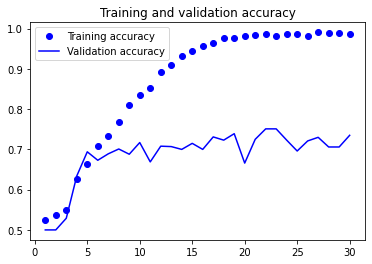

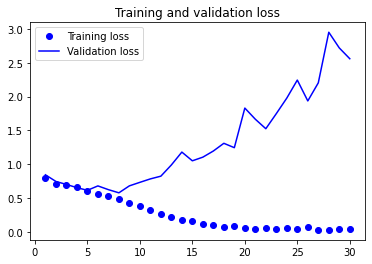

In [9]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

训练集上精度和损失都是随着迭代次数越来越理想.

验证集上精度最高大约是 75%,损失则是在第 8 轮左右达到最低.


In [10]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 40ms/step - loss: 0.5937 - accuracy: 0.6970
Test accuracy: 0.697


查看我们保存的模型,重新在测试集上评估,精度大约是 69.7%.书上是 69.5 +- 1 % 都正常.

这一阶段的目标达到了,有了一个可以过拟合的模型.而且效果比基线 50% 要好.

下一阶段是调整各种参数,使得泛化能力 Max.处理我们介绍过的 dropout 和正则化,图像领域还有一个专有的技术: 数据增强.


## 数据增强

过度拟合是训练的样本太少,导致模型想学习也学不到.如果数据是无限的,那么模型永远不会过拟合.

数据少,那从数据生成新的数据呢?大部分数据集这个选项根本不存在,但是这是图像啊,拉伸/变形/裁剪之后人眼还是认得的.数据增强就是这么干的.

一般是在模型前面串联一组数据增强层,数据增强会将一个输入图像,转换成很多新图像罐回模型.


In [11]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),# 50% 水平翻转
    layers.experimental.preprocessing.RandomRotation(0.1),# 图片随机旋转 +-10% (+-36°) 
    layers.experimental.preprocessing.RandomZoom(0.2),# 图片随机缩放 +-20%
])

上面只是数据增强的层可用的几个,更多见文档.

- `RandomFlip("horizontal")`: 50% 几率水平翻转.
- `RandomRotation(0.1)`: 图片随机旋转 +-10% (+-36°)
- `RandomZoom(0.2)`: 图片随机缩放 +-20%


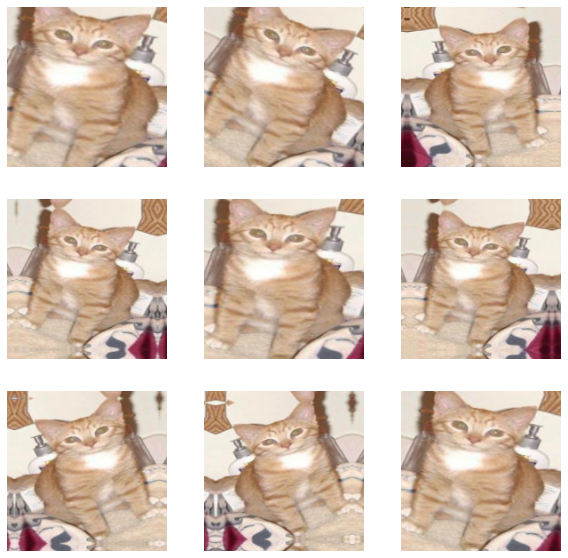

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

随机取一个图像,查看输出.


In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1. / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

一个直观的问题,虽然数据增强后的图像对于模型来说看起来并不一样,但是毕竟没有创建新的信息,只是原有信息的重组,仅仅这样对抗过拟合似乎还是不够.

这里在最终 cnn 输出连用了 dropout 层,以对抗过拟合.

**关于模型的最后一点**: 添加的 dropout 和 数据增强在测试集评估和预测时,不会存在.


In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=callbacks)


Epoch 1/100
63/63 [==============================] - 5s 63ms/step - loss: 0.7139 - accuracy: 0.5025 - val_loss: 0.6917 - val_accuracy: 0.5030
Epoch 2/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6984 - accuracy: 0.5430 - val_loss: 0.6828 - val_accuracy: 0.5910
Epoch 3/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6849 - accuracy: 0.5705 - val_loss: 0.6550 - val_accuracy: 0.6150
Epoch 4/100
63/63 [==============================] - 4s 63ms/step - loss: 0.6778 - accuracy: 0.5915 - val_loss: 0.6764 - val_accuracy: 0.5600
Epoch 5/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6580 - accuracy: 0.6120 - val_loss: 0.6522 - val_accuracy: 0.6180
Epoch 6/100
63/63 [==============================] - 4s 63ms/step - loss: 0.6400 - accuracy: 0.6385 - val_loss: 0.6349 - val_accuracy: 0.6330
Epoch 7/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6393 - accuracy: 0.6525 - val_loss: 0.6415 - val_accuracy: 0.6250
Epoch 

直接来个 100 次...我的 gpu 冒烟.jpeg...


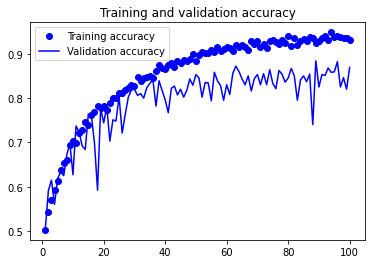

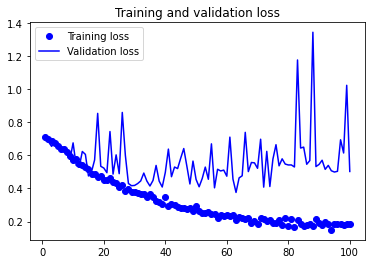

In [26]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

训练集上还是随着迭代次数增加,不断的提升.

验证集上准确度收敛在 80% ~ 85%.损失在在迭代 60 次左右达到最低. 

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 23ms/step - loss: 0.4818 - accuracy: 0.8360
Test accuracy: 0.836


在测试集的准确度 83.6% 比之前的提升很大.

按照正常流程,我们还会不断迭代调整参数,但是人是有极限的,这样模型的准确度可能到 90% 上下.

仅靠自己,使用这么少的数据,90% 就是极限了.但是复用其他大规模数据训练的模型,精度能再上一个台阶.
